# Sudoku solving with guided DDPM/DDIM (score model)

This notebook solves Sudoku puzzles using a pretrained score model and a **path-consistent DDPM/DDIM sampler**.

We do **not** simulate a Markov DDPM chain (which performs poorly in this domain).  
Instead, we directly invert the **same Gaussian probability path** that was used during training:
$$
x_t = \alpha(t)\,x_0 + \beta(t)\,\varepsilon,
\qquad
\varepsilon \sim \mathcal N(0,I).
$$

At each step the model predicts the noise component:
$$
\varepsilon_{\theta}(x_t,t) = -\beta(t)\,s_\theta(x_t,t),
$$

and we estimate the clean latent:
$$
\hat{z} = \frac{x_t - \beta(t)\,\varepsilon_{\theta}(x_t,t)}{\alpha(t)}.
$$

Then we advance to the next timestep $t'$ using the exact marginal distribution:
$$
x_{t'} = \alpha(t')\,\hat{z} + \beta(t')\,\eta,
\qquad
\eta \sim \mathcal N(0,I).
$$

- If `stochastic=True`, we draw $\eta \sim \mathcal N(0,I)$ → **DDPM (ancestral)**  
- If `stochastic=False`, we set $\eta=0$ → **DDIM (deterministic)**  

This sampler is numerically simple, stable, and **perfectly aligned with the forward path used during training**, unlike classical DDPM Markov chains which rely on per-step posterior approximations.

---

## Two-stage constraint enforcement (path → hard)

We enforce Sudoku givens ($m_i=1$ for fixed digits, $m_i=0$ otherwise) using a **two-stage strategy** controlled by a threshold time $\texttt{threshold\_hard}$.

Let $z$ denote the fixed puzzle digits embedded in the model input space.

---

### Stage A — Diffusion-consistent guidance ($t \le \texttt{threshold\_hard}$)

In the early, high-noise regime, we inject the givens at the **correct marginal noise level**:
$$
x_t^{\text{given}} = \alpha(t)\,z + \beta(t)\,\varepsilon,
\qquad
\varepsilon \sim \mathcal N(0,I).
$$

We overwrite constrained coordinates:
$$
x_t \leftarrow m \odot x_t^{\text{given}} + (1-m)\odot x_t.
$$

This ensures givens stay consistent with the forward noising process, preventing premature collapse or inconsistent noise structure.

---

### Stage B — Hard clamping guidance ($t > \texttt{threshold\_hard}$)

Once noise becomes small, we enforce Sudoku givens exactly:
$$
x_t \leftarrow m \odot z + (1-m)\odot x_t.
$$

This guarantees that the final generated Sudoku always respects the provided clues.

# Setup and useful functions

In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math
import time

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import imageio.v2 as imageio
from PIL import Image, ImageDraw, ImageFont


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == "cpu":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """ 
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
            - labels: shape (batch_size, label_dim)
        """
        pass

class IsotropicGaussian(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        shape: shape of sampled data
        """
        super().__init__()
        self.shape = shape
        self.std = std
        #self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...
        self.register_buffer("dummy", torch.zeros(1))
        
    def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

In [3]:
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        z, _ = self.sample_conditioning_variable(num_samples)
        x = self.sample_conditional_path(z, t)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        pass

In [4]:
class Alpha(ABC):
    def __init__(self):
        pass
        #for cosine and sine the condition is only approximately satisfied
        #assert torch.allclose(
        #    self(torch.zeros(1,1,1,1)), torch.zeros(1,1,1,1)
        #)
        # Check alpha_1 = 1
        #assert torch.allclose(
        #    self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1)
        #)
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)
    
class Beta(ABC):
    def __init__(self):
        pass
        #for cosine and sine the condition is only approximately satisfied
        #assert torch.allclose(
        #    self(torch.zeros(1,1,1,1)), torch.ones(1,1,1,1)
        #)
        # Check beta_1 = 0
        #assert torch.allclose(
        #    self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1)
        #)
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - beta_t (num_samples, 1, 1, 1)
        """ 
        pass 

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """ 
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)

class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return torch.ones_like(t)

class LinearBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        return 1-t
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return - torch.ones_like(t)

class CosineAlpha(Alpha):
    """
    Implements alpha_t = sin(0.5*pi*t)
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return torch.sin(0.5*math.pi*t)
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return 0.5*math.pi*torch.cos(0.5*math.pi*t)
        
class SinusBeta(Beta):
    """
    Implements beta_t = cos(0.5*pi*t)
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return torch.cos(0.5*math.pi*t)
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -0.5*math.pi*torch.sin(0.5*math.pi*t)
    
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        return self.p_data.sample(num_samples)


    def sample_conditioning_variable_by_index(self, idx: int) -> torch.Tensor:
        return self.p_data.sample_index(idx)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

    def conditional_score_no_beta(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x), beta_t ** 2

In [5]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - diffusion_coefficient: shape (bs, c, h, w)
        """
        pass

In [6]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, use_tqdm=True, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        iterator = range(nts - 1)
        if use_tqdm:
            iterator = tqdm(iterator)

        for t_idx in iterator:
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, use_tqdm=True, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]

        iterator = range(nts - 1)
        if use_tqdm:
            iterator = tqdm(iterator)

        for t_idx in iterator:
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)
        
def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

# Loading sudoku functions

In [7]:
def to_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().float().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x, dtype=np.float32)

def reshape_sudoku_probs(x_t81_9):
    x = to_numpy(x_t81_9)
    assert x.ndim == 3 and x.shape[1] == 81 and x.shape[2] == 9, f"Expected [T,81,9], got {x.shape}"
    return x.reshape(x.shape[0], 9, 9, 9)

def renormalize_per_cell(p_t99d, eps=1e-8):
    p = np.asarray(p_t99d, dtype=np.float32)
    s = p.sum(axis=-1, keepdims=True)
    s = np.where(s < eps, 1.0, s)
    return np.clip(p / s, 0.0, 1.0)

def entropy_map(p_t99d, eps=1e-8):
    p = np.clip(p_t99d, eps, 1.0)
    H = -(p * np.log(p)).sum(axis=-1)         
    Hmax = np.log(p.shape[-1])
    return H, (H / Hmax)

def confidence_map(p_t99d):
    pred = p_t99d.argmax(axis=-1)             
    conf = p_t99d.max(axis=-1)                
    return conf, pred

def render_guided_entropy_gif(
    p_t99d,
    z_given,                      # <-- NEW: one-hot givens, zeros for unknown
    out_path="entropy.gif",
    fps=20,
    cmap="magma",
    show_digits=True,
    digit_alpha_floor=0.15,
    add_grid=True,
):
    """
    p_t99d: array-like, shape (T, 9, 9, 9) or (T, 81, 9) depending on your helpers
    z_given: array-like, shape (81, 9) or (9, 9, 9)
             - one-hot row for given cell
             - all zeros row for unknown cell
    """

    # --- normalize shapes ---
    z_given = z_given.detach().cpu().numpy() if hasattr(z_given, "detach") else np.asarray(z_given)

    if z_given.ndim == 2:      # (81, 9)
        z_given_9x9x9 = z_given.reshape(9, 9, 9)
    elif z_given.ndim == 3:    # (9, 9, 9)
        z_given_9x9x9 = z_given
    else:
        raise ValueError(f"z_given must have shape (81,9) or (9,9,9), got {z_given.shape}")

    given_mask = (z_given_9x9x9.sum(axis=-1) > 0.5)   # (9,9) True where given
    given_digit = z_given_9x9x9.argmax(axis=-1) + 1   # (9,9) in 1..9 (meaningful only where given)

    # --- compute entropy + predictions ---
    p = renormalize_per_cell(p_t99d)
    _, Hn = entropy_map(p)          # expected shape (T,9,9) or (T,81) etc
    conf, pred = confidence_map(p)  # pred expected (T,9,9) with digits 0..8

    # ensure Hn/pred shapes are (T,9,9)
    Hn = np.asarray(Hn)
    pred = np.asarray(pred)
    conf = np.asarray(conf)

    if Hn.ndim == 2 and Hn.shape[1] == 81:  # (T,81)
        Hn = Hn.reshape(Hn.shape[0], 9, 9)
    if pred.ndim == 2 and pred.shape[1] == 81:
        pred = pred.reshape(pred.shape[0], 9, 9)
    if conf.ndim == 2 and conf.shape[1] == 81:
        conf = conf.reshape(conf.shape[0], 9, 9)

    frames = []
    T = Hn.shape[0]
    vmin, vmax = 0.0, 1.0

    # colormap where masked (=givens) is white
    cm = plt.get_cmap(cmap).copy()
    cm.set_bad(color="white")

    for t in range(T):
        fig, ax = plt.subplots(figsize=(5.6, 5.6), dpi=160)

        # mask entropy on givens -> render as white
        H_masked = np.ma.array(Hn[t], mask=given_mask)

        im = ax.imshow(H_masked, vmin=vmin, vmax=vmax, cmap=cm)
        ax.set_title(f"Sudoku entropy (normalized)   t={t}")

        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, 8.5)
        ax.set_ylim(8.5, -0.5)

        if add_grid:
            for k in range(10):
                ax.axhline(k - 0.5, linewidth=1.0)
                ax.axvline(k - 0.5, linewidth=1.0)
            for k in [0, 3, 6, 9]:
                ax.axhline(k - 0.5, linewidth=3.2)
                ax.axvline(k - 0.5, linewidth=3.2)

        if show_digits:
            for r in range(9):
                for c in range(9):
                    if given_mask[r, c]:
                        # given digit: black, fully opaque, on white background
                        d = int(given_digit[r, c])
                        ax.text(
                            c, r, str(d),
                            ha="center", va="center",
                            fontsize=12,
                            color="black",
                            alpha=1.0
                        )
                    else:
                        # predicted digit
                        d = int(pred[t, r, c]) + 1
                        a = float(conf[t, r, c])
                        ax.text(
                            c, r, str(d),
                            ha="center", va="center",
                            fontsize=12,
                            color="white",
                        )

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label("entropy (0=confident, 1=uniform)")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()

        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape((h, w, 4))
        frame = buf[..., :3].copy()
        frames.append(frame)
        plt.close(fig)

    # pause on last frame
    for _ in range(20):
        frames.append(frames[-1])

    imageio.mimsave(out_path, frames, fps=fps)
    return out_path
    
    
def show_sudoku(cells):
    """
    cells: iterable of 81 ints (0–9). 0/None are shown as blanks.
    """
    if len(cells) != 81:
        raise ValueError("Need exactly 81 values.")
    sym = lambda v: "." if (v is None or v == 0) else str(v)
    row = lambda r: " ".join(sym(x) for x in r)
    line = "+-------+-------+-------+"
    out = [line]
    for i in range(9):
        r = cells[i*9:(i+1)*9]
        out.append("| " + " | ".join([row(r[0:3]), row(r[3:6]), row(r[6:9])]) + " |")
        if i % 3 == 2: out.append(line)
    print("\n".join(out))

def valid_sudoku81(s):
    if len(s) != 81:
        return False
    s = [int(x) for x in s]
    ok = set(range(1, 10))
    return all(
        set(s[i*9:(i+1)*9]) == ok and               # rows
        set(s[i::9]) == ok and                      # cols
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c]        # 3x3 boxes
            for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )

def sudoku81_report(s):
    if len(s) != 81:
        return "invalid length (need 81)"
    s = [int(x) for x in s]
    ok = set(range(1, 10))

    rows = sum(set(s[i*9:(i+1)*9]) == ok for i in range(9))
    cols = sum(set(s[i::9]) == ok for i in range(9))
    blks = sum(
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c] for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )
    return rows, cols, blks

def print_sudoku_report(rows, cols, blks):
    return (f"number of correct rows: {rows}/9\n"
            f"number of correct columns: {cols}/9\n"
            f"number of correct blocks: {blks}/9")

def draw_one_sudoku(ax, cells, gt=None, title=None):
    cells = np.asarray(cells).reshape(9, 9)
    if gt is not None:
        gt = np.asarray(gt).reshape(9, 9)

    ax.set_xlim(0, 9)
    ax.set_ylim(9, 0)
    ax.set_aspect("equal")
    ax.axis("off")

    # grid
    for i in range(10):
        lw = 2.2 if i % 3 == 0 else 0.8
        ax.plot([0, 9], [i, i], linewidth=lw, color="black")
        ax.plot([i, i], [0, 9], linewidth=lw, color="black")

    # digits
    for r in range(9):
        for c in range(9):
            v = int(cells[r, c])
            if v == 0:
                continue

            color = "black"
            if gt is not None:
                color = "green" if v == int(gt[r, c]) else "red"

            ax.text(c + 0.5, r + 0.62, str(v),
                    ha="center", va="center",
                    fontsize=14, color=color)

    if title:
        ax.set_title(title, fontsize=10)
    
def draw_sudoku_path(cells_history, gt=None, titles=None, figsize_per=2.2, dpi=150):
    T = len(cells_history)
    fig, axes = plt.subplots(1, T, figsize=(figsize_per * T, figsize_per), dpi=dpi)

    # if T==1, axes is not a list
    if T == 1:
        axes = [axes]

    for i, (ax, cells) in enumerate(zip(axes, cells_history)):
        title = titles[i] if titles is not None else None
        draw_one_sudoku(ax, cells, gt=gt, title=title)

    plt.tight_layout()
    plt.show()

def correlation_report(x, y, name_x="x", name_y="y"):
    x = np.asarray(x)
    y = np.asarray(y)

    # Pearson (linear)
    try:
        from scipy.stats import pearsonr, spearmanr, kendalltau
        pr, pp = pearsonr(x, y)
        sr, sp = spearmanr(x, y)
        kt, kp = kendalltau(x, y)
    except Exception:
        # Fallbacks (no p-values)
        pr = np.corrcoef(x, y)[0, 1]
        # Spearman fallback: rank correlation
        rx = np.argsort(np.argsort(x))
        ry = np.argsort(np.argsort(y))
        sr = np.corrcoef(rx, ry)[0, 1]
        kt, kp, pp, sp = np.nan, np.nan, np.nan, np.nan

    print(f"Correlation between {name_x} and {name_y}:")
    print(f"  Pearson r   = {pr:.4f} (p={pp})")
    print(f"  Spearman ρ  = {sr:.4f} (p={sp})")
    print(f"  Kendall τ   = {kt:.4f} (p={kp})")



# Network architecture

In [8]:
class TimeFourier(nn.Module):
    def __init__(self, dim=64, max_freq=1000.0):
        super().__init__()
        half = dim // 2
        freqs = torch.exp(torch.linspace(0, math.log(max_freq), half))
        self.register_buffer("freqs", freqs)
        self.dim = dim

    def forward(self, t):
        # t: (B, 1)
        x = t * self.freqs[None, :] * 2 * math.pi  # (B, half)
        emb = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # (B, 2*half)
        if emb.shape[-1] < self.dim:  
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb  # (B, dim)


class TransformerBlock(nn.Module):
    def __init__(self, hidden=128, heads=8, mlp_ratio=4.0, dropout=0.01):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden)
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden, num_heads=heads, dropout=dropout, batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden)

        mlp_hidden = int(hidden * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden, mlp_hidden),
            nn.GELU(),
            nn.Linear(mlp_hidden, hidden),
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        # x: (B, 81, hidden)
        h = self.ln1(x)
        a, _ = self.attn(h, h, h, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        x = x + self.drop(a)             
        x = x + self.drop(self.mlp(self.ln2(x))) 
        return x


class SudokuAttentionVectorField(nn.Module):
    """
    A simple attention-based vector field / refinement model.

    Inputs:
      z: (B, 81, 9)  - per-cell 9-dim state (logits/probs/features)
      t: (B, 1)      - time / step

    Output:
      dz: (B, 81, 9) - update direction (same shape as z)
    """
    def __init__(self, hidden: int = 128, depth: int = 4, heads: int = 8, t_dim: int = 64, dropout: float = 0.01):
        super().__init__()
        self.time = TimeFourier(t_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(t_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )

        # project per-cell state (9) into hidden token embedding
        self.in_proj = nn.Linear(9, hidden)

        # positional identity for Sudoku grid
        self.row_emb = nn.Embedding(9, hidden)
        self.col_emb = nn.Embedding(9, hidden)
        self.box_emb = nn.Embedding(9, hidden)

        # precompute (81,) indices as buffers
        rows = torch.arange(81) // 9
        cols = torch.arange(81) % 9
        boxs = (rows // 3) * 3 + (cols // 3)
        self.register_buffer("row_idx", rows, persistent=False)
        self.register_buffer("col_idx", cols, persistent=False)
        self.register_buffer("box_idx", boxs, persistent=False)

        self.blocks = nn.ModuleList([
            TransformerBlock(hidden=hidden, heads=heads, dropout=dropout)
            for _ in range(depth)
        ])

        self.out_ln = nn.LayerNorm(hidden)
        self.out_proj = nn.Linear(hidden, 9)

    def forward(self, z: torch.Tensor, t: torch.Tensor, attn_mask=None) -> torch.Tensor:
        # z: (B,81,9), t: (B,1)
        x = self.in_proj(z)  # (B,81,H)

        # add Sudoku coordinate embeddings
        pos = (self.row_emb(self.row_idx) +
               self.col_emb(self.col_idx) +
               self.box_emb(self.box_idx))  # (81,H)
        x = x + pos[None, :, :]  # (B,81,H)

        te = self.t_proj(self.time(t))  # (B,H)
        x = x + te[:, None, :]          # broadcast add time conditioning

        for blk in self.blocks:
            x = blk(x, attn_mask=attn_mask)

        x = self.out_ln(x)
        dz = self.out_proj(x)  # (B,81,9)
        return dz


# DDPM ancestral sampler 

In [9]:
def make_time_grid(num_steps: int, eps: float = 1e-4, device=None):
    """
    Returns t_grid of shape (num_steps+1,) in [0,1], slightly truncated to avoid endpoints.
    We keep t=0 (pure noise) and t=1 (pure data),
    but for training we avoid exact 0/1 to prevent singularities.
    """
    # grid includes endpoints, then we clamp slightly inward
    t = torch.linspace(0.0, 1.0, num_steps + 1, device=device)
    if eps is not None and eps > 0:
        t = torch.clamp(t, eps, 1.0 - eps)
    return t

class DDPMSimulator(Simulator):
    def __init__(self, model, path, ts_1d, stochastic: bool = True):
        """
        Path-consistent ancestral sampler for

            x_t = alpha(t) * x0 + beta(t) * eps

        Time convention:
            t in [0,1], 0 ~ noise, 1 ~ data.

        Args:
            model: score model s_theta(x, t)
            path:  object with .alpha(t), .beta(t)
            ts_1d: 1D tensor of times in (0,1), increasing (0 -> 1).
            stochastic: if False, uses deterministic noise=0 at each step.
        """
        self.model = model
        self.path = path
        self.ts = ts_1d              # increasing: noise -> data
        self.nts = ts_1d.numel()
        self.stochastic = stochastic
        self._k = 0                  # current time index

    def reset_k(self):
        self._k = 0
        
    def update_time(self, num_samples):
        ts_1d = make_time_grid(num_samples)
        self.ts = ts_1d.view(1, -1, 1, 1, 1).repeat(num_samples, 1, 1, 1, 1)
        self.reset_k()

    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        One ancestral step:

            x(t_k) -> x(t_{k+1})

        using:
            eps_pred = -beta(t_k) * s_theta(x_t, t_k)
            z_hat    = (x_t - beta(t_k) * eps_pred) / alpha(t_k)
            x_next   = alpha(t_{k+1}) * z_hat + beta(t_{k+1}) * noise
        """
        k = self._k
        # already at (or beyond) last time -> nothing more to do
        if k >= self.nts - 1:
            return xt

        bs = xt.shape[0]
        device = xt.device

        # current and next times
        t_k = self.ts[k].view(1, 1, 1).to(device).expand(bs, 1, 1)
        t_next = self.ts[k + 1].view(1, 1, 1).to(device).expand(bs, 1, 1)

        # score model
        s = self.model(xt, t_k.view(bs, 1), **kwargs)

        # eps_pred = -beta(t_k) * score
        beta_k = self.path.beta(t_k)           # (bs,1,1)
        alpha_k = self.path.alpha(t_k)         # (bs,1,1)
        eps_pred = -beta_k * s                 # same shape as xt

        # latent estimate z_hat
        z_hat = (xt - beta_k * eps_pred) / alpha_k

        # choose noise for next step
        if self.stochastic:
            noise = torch.randn_like(xt)
        else:
            noise = torch.zeros_like(xt)

        # forward to t_{k+1}
        alpha_next = self.path.alpha(t_next)
        beta_next = self.path.beta(t_next)
        nxt = alpha_next * z_hat + beta_next * noise

        self._k += 1
        return nxt

class GuidedPathDDPMSimulator(Simulator):
    def __init__(self, model, path, ts_1d, threshold_hard: float = 1.0, stochastic: bool = True):
        """
        Path-consistent ancestral sampler with hard guidance.

        x_t = alpha(t) * x0 + beta(t) * eps

        Args:
            model:     score model s_theta(x, t)
            path:      object with .alpha(t), .beta(t), .sample_conditional_path(z, t)
            ts_1d:     1D tensor of times in (0,1), increasing (0 -> 1),
                       same grid as used in training (e.g. make_time_grid).
            threshold_hard: time threshold for guidance logic:
                - for t <= threshold_hard: inject guided noisy path under mask
                - for t >  threshold_hard: hard-clamp masked positions to z_guided
            stochastic: if False, uses deterministic noise=0 at each step.
        """
        self.model = model
        self.path = path
        self.ts = ts_1d              # increasing: noise -> data
        self.nts = ts_1d.numel()
        self.stochastic = stochastic
        self.threshold_hard = threshold_hard
        self._k = 0                  # current time index

    def reset_k(self):
        self._k = 0
        
    def update_time(self, num_samples):
        ts_1d = make_time_grid(num_samples)
        self.ts = ts_1d.view(1, -1, 1, 1, 1).repeat(num_samples, 1, 1, 1, 1)
        self.reset_k()

    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor,
             z_guided: torch.Tensor, mask: torch.Tensor, path=None, **kwargs):
        """
        Guided ancestral step:

            x(t_k) -> x(t_{k+1})

        Guidance rules (similar to GuidedPathEulerMaruyamaSimulator):

            - If t_k <= threshold_hard:
                * sample x_guided ~ path(z_guided, t_k)
                * replace xt under mask with x_guided

            - Ancestral diffusion step.

            - If t_k > threshold_hard:
                * hard-clamp masked positions to z_guided
        """
        k = self._k
        if k >= self.nts - 1:
            return xt

        bs = xt.shape[0]
        device = xt.device

        # scalar current time
        t_k_scalar = self.ts[k]
        t_k = t_k_scalar.view(1, 1, 1).to(device).expand(bs, 1, 1)
        t_next = self.ts[k + 1].view(1, 1, 1).to(device).expand(bs, 1, 1)

        # --- pre-step guidance (soft, noisy) ---
        if t_k_scalar <= self.threshold_hard:
            # sample guided noisy state at time t_k and inject under mask
            x_guided = self.path.sample_conditional_path(z_guided, t_k)
            xt = x_guided * mask + (1.0 - mask) * xt

        # --- standard path-consistent ancestral step ---
        s = self.model(xt, t_k.view(bs, 1), **kwargs)

        beta_k = self.path.beta(t_k)
        alpha_k = self.path.alpha(t_k)
        eps_pred = -beta_k * s

        z_hat = (xt - beta_k * eps_pred) / alpha_k

        if self.stochastic:
            noise = torch.randn_like(xt)
        else:
            noise = torch.zeros_like(xt)

        alpha_next = self.path.alpha(t_next)
        beta_next = self.path.beta(t_next)
        nxt = alpha_next * z_hat + beta_next * noise

        # --- post-step hard guidance ---
        if t_k_scalar > self.threshold_hard:
            nxt = z_guided * mask + (1.0 - mask) * nxt

        self._k += 1
        return nxt

# Score matching

In [10]:
score_model = SudokuAttentionVectorField()

In [11]:
state_dict = torch.load("ddpm_latest.pt", map_location="cpu")
score_model.load_state_dict(state_dict)
score_model = score_model.to(device)

In [12]:
#losses = trainer.train(num_epochs=100_000, device=device, lr=1e-3, batch_size=2_000)

# Solving a custom Sudoku

Below we solve a user-defined Sudoku instance (encoded as an 81-length vector with zeros for blanks).  
Note that Sudoku difficulty varies significantly across instances: puzzles with very few givens (e.g., 17–20 clues) are typically challenging because the conditioning signal is weak and the solver must resolve many global constraints.

## Runtime notes (stochastic solver + early stopping)

Our sampler is **stochastic**: each trajectory may or may not land on a valid Sudoku solution.  
Therefore, we generate solutions in **parallel batches** and apply **early stopping**:

- In each run we sample a batch of `num_samples` candidate solutions (trajectories).
- We validate all candidates and **stop immediately** once at least one valid solution is found.
- This makes the method an **anytime algorithm**: more compute increases the probability of success.

In practice, hard instances can require multiple batches. However, batch sampling is **parallel** and scales well with available GPU resources.

In [13]:
custom_sudoku_ultra_hard = [1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
       2, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
       5, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 7, 0, 0, 6,
       0, 0, 0, 0, 0, 0, 0, 9, 4, 0, 0, 0, 0, 0, 0]

custom_sudoku_easy = [1, 5, 0, 3, 4, 0, 0, 0, 9, 0, 0, 2, 0, 0, 0, 0, 3, 8, 0, 9, 4, 6,
       7, 0, 0, 0, 0, 4, 0, 6, 0, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, 7, 0, 8,
       0, 0, 0, 7, 0, 9, 0, 2, 0, 0, 0, 8, 0, 0, 0, 1, 7, 0, 4, 9, 7, 0,
       0, 6, 0, 0, 5, 3, 2, 0, 0, 0, 0, 0, 0, 6, 0]

custom_sudoku_medium = [6, 0, 5, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 7, 0, 0, 3, 0, 3, 0, 0,
       9, 0, 0, 1, 0, 0, 0, 4, 2, 8, 0, 0, 0, 5, 1, 0, 8, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 1, 6, 2, 9, 0, 0, 0, 0, 0,
       9, 0, 0, 0, 0, 7, 3, 1, 0, 0, 4, 5, 0, 0, 0]

custom_sudoku_hard = [0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 1, 2, 0, 9, 0, 0, 0, 1, 0, 9,
       0, 0, 0, 0, 8, 0, 9, 0, 0, 0, 2, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 7, 0, 0, 0, 9, 2, 8, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 1, 8, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 7]

custom_sudoku = custom_sudoku_hard
custom_sudoku = np.array(custom_sudoku)
mask = (custom_sudoku == 0).reshape(-1,1)
custom_sudoku_one_hot = np.eye(9)[custom_sudoku - 1]
z_custom_given = custom_sudoku_one_hot*(1-mask)
z_custom_given = z_custom_given.reshape(1, 81, 9)
z_custom_given = torch.tensor(z_custom_given).float().to(device)

In [14]:
num_samples= 500
num_timesteps = 400
num_marginals = 4
num_cols = 1
num_rows = num_marginals
stochastic=True

torch.cuda.manual_seed(15)

start = time.time()

z = z_custom_given
z_given = z_custom_given
mask = torch.sum(z_given, -1, keepdims=True)

class DummySampler:
    """
    Minimal sampler that returns fixed (z, z_given).
    """
    def __init__(self, z, z_given):
        self.z = z
        self.z_given = z_given

    def sample(self, num_samples: int):
        """
        Ignores num_samples and returns provided tensors.
        """
        return self.z, self.z_given

sampler = DummySampler(z, z_given)

path_test = GaussianConditionalProbabilityPath(
    p_data = sampler,
    p_simple_shape = [81, 9],
    alpha = CosineAlpha(),
    beta = SinusBeta()
).to(device)

ts_1d = make_time_grid(num_timesteps) 
ts = ts_1d.view(1, -1, 1, 1, 1).repeat(num_samples, 1, 1, 1, 1)

threshold= 0.6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 59.93it/s]


Runs taken: 3.
Time spent: 0 min 27.2 s
Valid sudokus:1/500


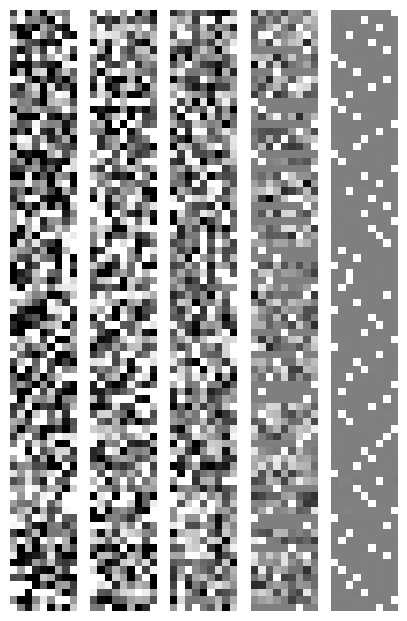

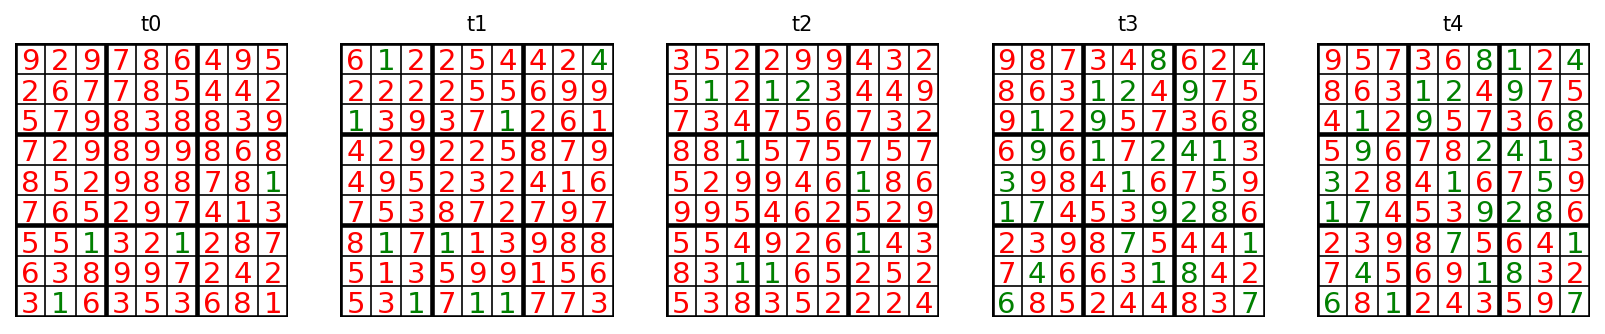

In [15]:
for threshold in [0.6]:
    print("threshold=", threshold)
    for j in range(100):
        threshold_hard = threshold#np.random.choice([0.0, 0.4, 0.45, 0.5, 0.8])
        cur_model =  lambda x, t : score_model(x,t.reshape(-1,1))
        simulator = GuidedPathDDPMSimulator(cur_model, path_test, ts_1d, threshold_hard=threshold_hard, stochastic=stochastic)
        #sampling noise
        x0, _ = path_test.p_simple.sample(num_samples) 

        #running simulator with the score model
        # here we visualize the trajectory, so we keep track of it
        # use simulator.simulate if you want just a solution!
        
        xts = simulator.simulate_with_trajectory(x0, ts, z_guided=z_given, mask=mask,use_tqdm=True) # (bs, nts, dim)
        solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()
        
        #xts = simulator.simulat(x0, ts, z_guided=z_given, mask=mask, path=path, use_tqdm=False) # (bs, nts, dim)
        #solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()
    
       
        report = [sudoku81_report(sol+1) for sol in solutions]
        report = np.array(report)
        
        i = 0
        if np.max(np.mean(report, -1)) == 9:
            i = np.argmax(np.mean(report, -1))
        
        indexes = np.where(np.mean(report, -1) == 9)
        if np.sum(np.mean(report, -1) == 9) > 0:
            break
    print(f"Runs taken: {j}.")
    elapsed = time.time() - start
    mins, secs = divmod(elapsed, 60)
    print(f"Time spent: {int(mins)} min {secs:.1f} s")
    print(f"Valid sudokus:{np.sum([valid_sudoku81(sol+1) for sol in solutions])}/{len(solutions)}")
        
    cells_history = []
    every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
    
    xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
    ts_every_n = ts[0,every_n] # (nts // n,)
    
    fig, axes = plt.subplots(1, xts_every_n.shape[1], figsize=((num_cols * xts_every_n.shape[1]), 6 * num_rows))
    for plot_idx in range(xts_every_n.shape[1]):
        tt = ts_every_n[plot_idx].view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
        xt = xts_every_n[i, plot_idx]
        grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
        axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
        axes[plot_idx].axis("off")
    
        cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
    plt.show()
    
    gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
    draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])
    
